In [1]:
# Navigating to the directory containing the snapshots
import os
os.chdir(r"D:\Abhinav Tar Files\Snapshots")

Processed 1/802 snapshots (s=0)
Processed 2/802 snapshots (s=1)
Processed 3/802 snapshots (s=2)
Processed 4/802 snapshots (s=3)
Processed 5/802 snapshots (s=4)
Processed 6/802 snapshots (s=5)
Processed 7/802 snapshots (s=6)
Processed 8/802 snapshots (s=7)
Processed 9/802 snapshots (s=8)
Processed 10/802 snapshots (s=9)
Processed 11/802 snapshots (s=10)
Processed 12/802 snapshots (s=11)
Processed 13/802 snapshots (s=12)
Processed 14/802 snapshots (s=13)
Processed 15/802 snapshots (s=14)
Processed 16/802 snapshots (s=15)
Processed 17/802 snapshots (s=16)
Processed 18/802 snapshots (s=17)
Processed 19/802 snapshots (s=18)
Processed 20/802 snapshots (s=19)
Processed 21/802 snapshots (s=20)
Processed 22/802 snapshots (s=21)
Processed 23/802 snapshots (s=22)
Processed 24/802 snapshots (s=23)
Processed 25/802 snapshots (s=24)
Processed 26/802 snapshots (s=25)
Processed 27/802 snapshots (s=26)
Processed 28/802 snapshots (s=27)
Processed 29/802 snapshots (s=28)
Processed 30/802 snapshots (s=29)

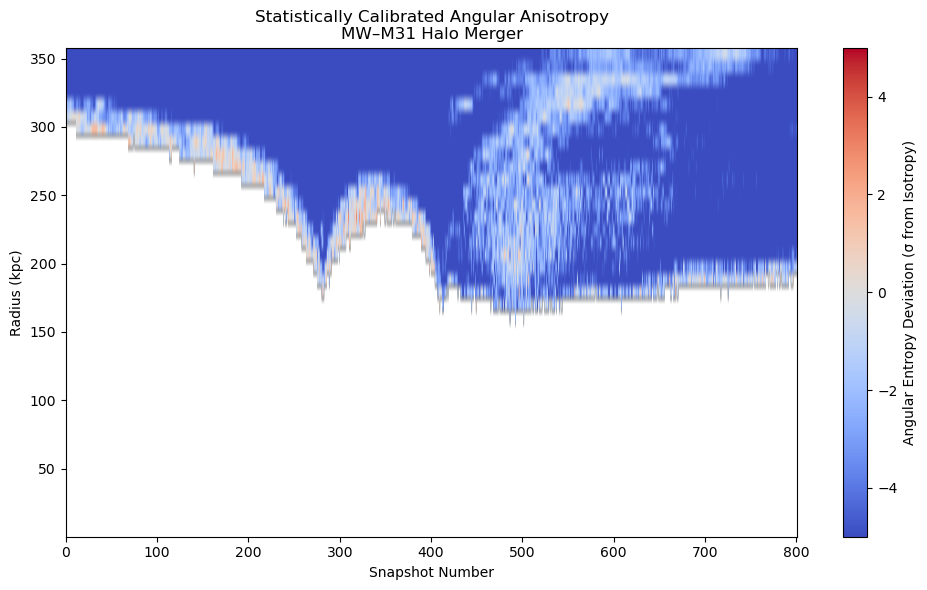

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from CenterOfMass2 import CenterOfMass
import warnings

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================

# Snapshot range
start_snap = 0
end_snap = 801
snaps = np.arange(start_snap, end_snap + 1)
nsnaps = len(snaps)

# Radial binning (logarithmic to resolve inner halo and outskirts)
r_bins = np.logspace(-1, 2.6, 40)
r_mid = np.sqrt(r_bins[:-1] * r_bins[1:])
nbins = len(r_mid)

# Angular discretization
# Chosen to balance angular resolution and particle noise
n_theta = 12
n_phi = 24
n_ang_bins = n_theta * n_phi

# Monte Carlo calibration for shot noise
n_mc = 100  # sufficient for stable mean and variance

# Storage for bias-corrected entropy significance
angular_entropy_z = np.full((nsnaps, nbins), np.nan)

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def spherical_angles(pos):
    """
    Convert Cartesian positions into spherical coordinates.

    Notes
    -----
    Only angular coordinates are used in the entropy calculation.
    The radial coordinate is used solely for shell selection.
    """
    r = np.linalg.norm(pos, axis=1)
    theta = np.arccos(np.clip(pos[:, 2] / r, -1, 1))
    phi = np.mod(np.arctan2(pos[:, 1], pos[:, 0]), 2 * np.pi)
    return r, theta, phi


def angular_entropy(theta, phi, masses):
    """
    Compute normalized Shannon entropy of a mass-weighted
    angular distribution on a spherical shell.

    Returns
    -------
    S_norm : float
        Entropy normalized by the maximum possible entropy.
    """
    theta_bins = np.linspace(0, np.pi, n_theta + 1)
    phi_bins = np.linspace(0, 2 * np.pi, n_phi + 1)

    hist = np.zeros((n_theta, n_phi))

    theta_idx = np.digitize(theta, theta_bins) - 1
    phi_idx = np.digitize(phi, phi_bins) - 1

    valid = (
        (theta_idx >= 0) & (theta_idx < n_theta) &
        (phi_idx >= 0) & (phi_idx < n_phi)
    )

    for t, p, m in zip(theta_idx[valid], phi_idx[valid], masses[valid]):
        hist[t, p] += m

    total_mass = np.sum(hist)
    if total_mass == 0:
        return np.nan

    prob = hist.flatten() / total_mass
    prob = prob[prob > 0]

    S = -np.sum(prob * np.log(prob))
    S_max = np.log(n_ang_bins)

    return S / S_max


def isotropic_entropy_mc(N, masses):
    """
    Monte Carlo calibration of entropy for an isotropic distribution
    with the same particle count and mass distribution.

    This corrects for the finite-N downward bias of Shannon entropy.
    """
    S_vals = []

    for _ in range(n_mc):
        # Sample isotropic angles
        u = np.random.uniform(-1, 1, N)
        theta = np.arccos(u)
        phi = np.random.uniform(0, 2 * np.pi, N)

        S_vals.append(angular_entropy(theta, phi, masses))

    return np.mean(S_vals), np.std(S_vals)

# ============================================================
# MAIN ANALYSIS LOOP
# ============================================================

processed = 0

for i, s in enumerate(snaps):
    mw_file = f"MW_{s:03d}.txt"
    m31_file = f"M31_{s:03d}.txt"

    try:
        MW = CenterOfMass(mw_file, 1)
        M31 = CenterOfMass(m31_file, 1)
        processed += 1
        print(f"Processed {processed}/{nsnaps} snapshots (s={s})")
    except Exception:
        continue

    # Combine MW and M31 particles into a single system
    x = np.concatenate((MW.x, M31.x))
    y = np.concatenate((MW.y, M31.y))
    z = np.concatenate((MW.z, M31.z))
    m = np.concatenate((MW.m, M31.m))
    pos = np.vstack((x, y, z)).T

    # --------------------------------------------------------
    # CENTERING FIX:
    # Use the total MW+M31 center of mass.
    # This removes trivial dipoles from orbital separation
    # and ensures entropy probes internal angular structure.
    # --------------------------------------------------------
    Mtot = np.sum(m)
    xcom = np.sum(x * m) / Mtot
    ycom = np.sum(y * m) / Mtot
    zcom = np.sum(z * m) / Mtot

    pos -= np.array([xcom, ycom, zcom])

    # Convert to spherical coordinates
    r, theta, phi = spherical_angles(pos)

    # --------------------------------------------------------
    # Compute bias-corrected angular entropy per radial shell
    # --------------------------------------------------------
    for b in range(nbins):
        shell = (r >= r_bins[b]) & (r < r_bins[b + 1])
        N = np.sum(shell)

        # Require sufficient sampling
        if N < 50:
            continue

        # Measured entropy
        S_meas = angular_entropy(theta[shell], phi[shell], m[shell])

        # Shot-noise calibration
        S_iso_mean, S_iso_std = isotropic_entropy_mc(N, m[shell])

        if S_iso_std > 0:
            # Z-score–like deviation from isotropy
            angular_entropy_z[i, b] = (S_meas - S_iso_mean) / S_iso_std

# ============================================================
# VISUALIZATION
# ============================================================

plt.figure(figsize=(10, 6))

im = plt.imshow(
    angular_entropy_z.T,
    origin="lower",
    aspect="auto",
    extent=[snaps[0], snaps[-1], r_mid[0], r_mid[-1]],
    cmap="coolwarm",
    vmin=-5,
    vmax=5
)

plt.colorbar(im, label="Angular Entropy Deviation (σ from Isotropy)")
plt.ylabel("Radius (kpc)")
plt.xlabel("Snapshot Number")
plt.title("Statistically Calibrated Angular Anisotropy\nMW–M31 Halo Merger")

plt.tight_layout()
plt.savefig("angular_entropy_zscore_evolution.png", dpi=300)
plt.show()
